# Avito Demand Prediction Challenge
# Mid-Term Presentation 

# Content

1. Challenge Overview
2. Data Exploration
3. Our Models

# Challenge Overview:

## What is Avito?

Basically russian version of eBay.

## Goal: Demand Prediction

Predict demand for advertisements based on full description, context and similar ads, to help sellers optimize their listings.

### All kinds of advertisements:

![](tiere.png)
![](houses.png)
![](stuff.png)


### Detailed look at advertisement:

![](offer1.png)
![](offer2.png)

### Main Problem of Challenge: Combining Text, Image, Categorical and Numeric Data

# Data Exploration:

## Competition Data:

In [1]:
# Import Packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import random 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load train_df and test_df
train_df = pd.read_csv("../data/train.csv", parse_dates=["activation_date"])#, nrows=1000)
test_df = pd.read_csv("../data/test.csv", parse_dates=["activation_date"])#, nrows=1000)

### Main Files:
#### train_csv - aprox. 1.5 million ads, with description, title, region... and deal_probability
#### test_csv - same structure as train_csv, without deal_probability

In [8]:
train_df.head().to_csv('head.csv')

In [3]:
# print train_df head
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


### Additional Files:
#### train_jpg.zip: ~50 GB of images for training set
#### test_jpg.zip: ~20 GB of images for test set
#### train_active.csv: supplemental data for training set, ads that were displayed in the same timeframe without images and deal probabiltily
#### test_active.csv: supplemental data for test set
#### periods_train: supplemental data for train_active containing the dates when the ads were activated and when they were shown
#### periods_test: same for test set

### Missing Values:

In [4]:
# checking missing data in training data 
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head(10)

,Total,Percent
param_3,862565,57.373369
param_2,654542,43.536753
description,116276,7.734079
image,112588,7.488772
image_top_1,112588,7.488772
price,85362,5.677839
param_1,61576,4.095718
category_name,0,0.000000
user_id,0,0.000000
region,0,0.000000


### Deal Probability Histogram

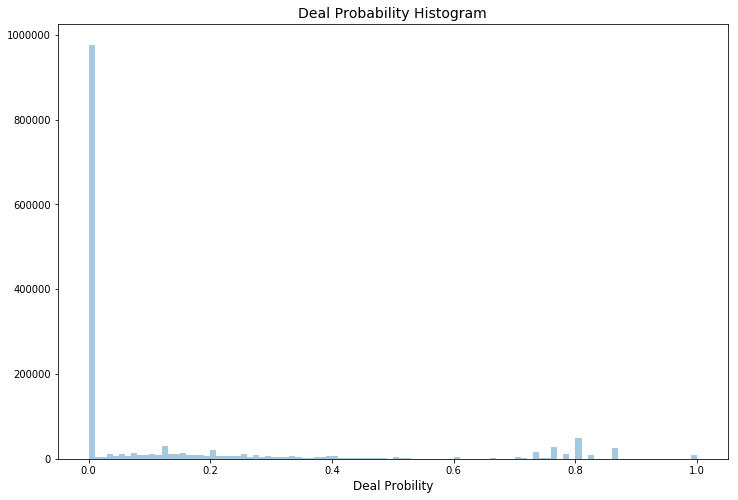

In [5]:
# Plot Deal Probability
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

In [6]:
# load Dataframe including text features
preprocessed_df = pd.read_csv("/home/jonas/Documents/Uni/DataChallenge/joprosigi/dataframe_text_features.csv", index_col=0)#, nrows=1000)


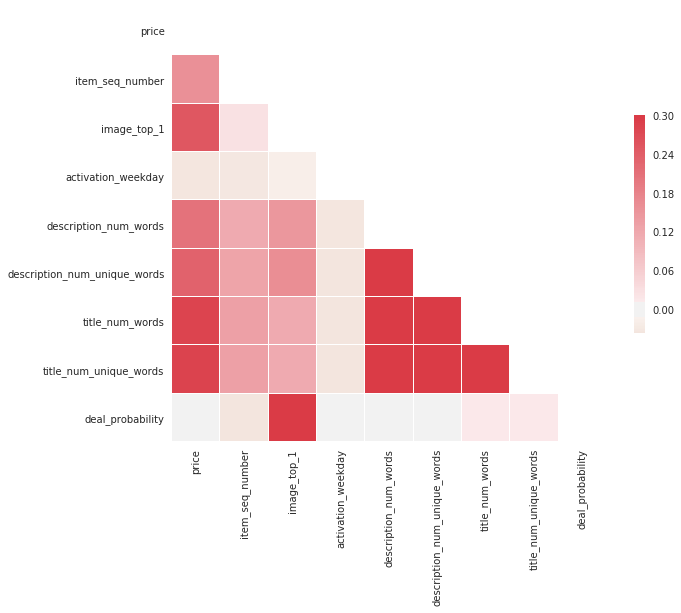

In [7]:
#Correlation Matrix
corr_cols = ['price', 'item_seq_number', 'image_top_1', 'activation_weekday', 'description_num_words', 'description_num_unique_words', 'title_num_words', 'title_num_unique_words', 'deal_probability']
corr = preprocessed_df[corr_cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

## Models: Gradient Boosting vs. Neural Networks

The best Models on Leaderboard are between RMSE of 0.215 and 0.22, but we don't know how they achieved these results. Probably a combination of computational power, effort and model blending.

### Gradient Boosting:

#### What is Gradient Boosting?
Gradient Boosting is a regression technique, which combines multiple weak prediction models to a strong model.

Most popular : LightGBM based on Decision Trees, fast and memory efficient while delivering good results.   

### What we did so far:

    - Data Cleaning (Deal with Na's, removed colums eg. user_id, item_id)
    - normalize price
    - encoding for categorical variables (rmse: 0.2316 -> 0.2311)
    - text feature extraction
    - tf-idf (rmse: 0.226)

### Outlook:

    - add image data (manual image features(resolution, noise...) and deep learning features)
    - dimension reduction on tf-idf results
    - incorporate supplemental data (how many items per user, average activation time...)


### Neural Network: Deep-And-Wide Network

Combine multiple networks into a big one. In this case one for text, images and one for remaining features.

### What we did so far:
#### Images: 
    - Features from Xception network pretrained on ImageNet
    - fine tuning on top 10 layers
    - results in 256 image features

#### Text:
    - use word embeddings trained on russian wikipedia
    - convolutional neural network on top of word embeddings
    - results in 256 text features

#### Remaining Features:
    - Train embeddings for categorical variables
    - about 80 features

Concatenate features from all three networks and perform regression with fully connected layers.

### Outlook:
    - play around with architecture
    - try training word embeddings
    - compare CNN and RNN
    - try tf-idf
    - incorporate supplemental data
    
    
    
## Conclusion
    - Different kinds of data affect model architectures
    - Gradient Boosting needs multiple feature extraction methods
    - Neural Network needs deep-and-wide architecture
    - model blending can help combine strengths of different modelsF